We want to use the model and algorithm of Tutorial--Van der Pol's dynamics with spike train observations.ipynb on the data in the folder Data. This notebook is used to create models for the data.

In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle

# .py
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE
sys.path.append("../Data")
from Load_plot_data import load_neuron_data, roster_plot

# Load the data and modify its format

In [2]:
#Load data
ids,times=load_neuron_data('../Data/Cellline1_Date190328_Chip2135.npz')
N=np.max(ids) # Number of neurons
trLen=np.array([np.max(times)]) #Tmax must be an array to have one for each trial
print(trLen)

[897.9968]


The data from the files is of the form
( id : neurons ids,
times : times of spike )

For the model we need a list of array where array i contains the times at which neuron i had a spike

We can observe using unique and some tests that the ids are all the numbers between 0 and 1016 except 131 and 899. We suppose that they are not present beacause they didn't have a spike.

In [3]:
Yspike=[]
for i in range(N):
    Yspike.append(times[ids==i])
print(len(Yspike))

#For now there is only one trial, to change if we want to define trials
Yspike=[Yspike]

1016


353


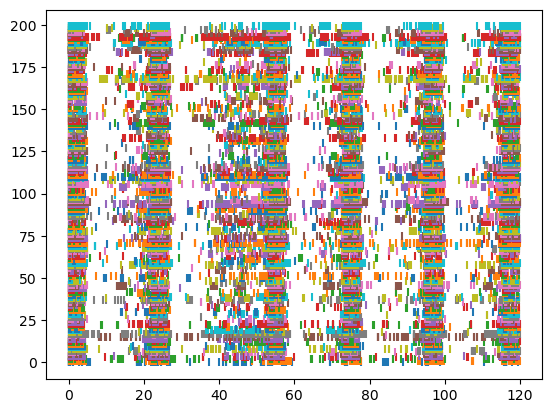

In [4]:
#Reduce the dataset (only one trial)
N=200
timemax=120

#Yspike=Yspike[0][:N] #keep only n first neuron

#seeds
torch.manual_seed(25)
np.random.seed(11) #C,d (very bad seed : 26,20)
random.seed(27) #neuron choice

#keep n most actives
Yspike=Yspike[0]
Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)[:3*N]
print(Yspike[-1].shape[0])
random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
Yspike=Yspike[:N]

for i in range(N):  #reduce the time
    Yspike[i]=Yspike[i][Yspike[i]<=timemax]
    plt.scatter(Yspike[i],i*np.ones(Yspike[i].shape[0]),marker='|')
plt.show()
Yspike=[Yspike]
trLen=np.array([timemax]) #Tmax must be an array to have one for each trial

# Choices for the model

In [5]:
#Choice of variables
dtgrid = 0.004 # discretisation for solving ODEs ,seems to influence spd
xDim = 2 # two latents

In [6]:
#Choice of model components
link = Exp() # exponential link function (to define nonlinearity in likelihood )
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood 
kern = RBF(xDim) # RBF kernel

#To initialize the Affine mapping from latent to observations
C = 3.*np.random.rand(xDim,N) * np.random.choice([-1,1],size=(xDim,N)) #before : 2.
#C = 2.*np.random.rand(xDim,N) 
d = 0.1*np.random.randn(1,N)
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping, used inn the forward of the model

In [7]:
#Choose the inducing points and transition function
#how to choose the inducing points? how to choose the number of inducing points ?

# generater inducing point locations on a 2D grid (for sparse gp)
xmin, xmax = -25, 25
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,5), torch.linspace(xmin,xmax,5)])
numZ = 25
Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)
#print(Zs)

transfunc = SparseGP(kern, Zs) # choose sparse GP as a transition function
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean
print(transfunc.q_mu)

# uncomment to instead condition on fixed points
#Zs_fx = torch.tensor([1., 1.]).view(-1,xDim)
#print(Zs_fx)
#transition function conditioned on fixed point
#transfunc = SparseGP(kern, Zs_fx)  should probably be FixedpointSparseGP, maybe use it ?

tensor([[ 1.2378,  0.2055],
        [ 2.0103,  0.8802],
        [ 1.5170,  0.1977],
        [ 0.2840, -0.8566],
        [-1.4239, -1.2585],
        [ 1.6184, -0.7784],
        [-0.0635,  0.6203],
        [ 0.0453, -0.6280],
        [-0.5307,  1.8680],
        [ 0.6825, -0.5218],
        [ 0.1668, -0.5829],
        [ 1.4985,  0.9988],
        [ 0.4504, -1.3124],
        [-2.0736,  0.0073],
        [ 0.0444, -0.8135],
        [ 1.8346, -0.4475],
        [-0.5623, -2.3450],
        [ 0.7125, -0.8866],
        [ 0.4008, -0.1310],
        [-0.8179, -0.6155],
        [-1.4112, -0.3595],
        [ 1.1657, -1.1956],
        [ 1.0075, -1.1623],
        [ 0.9317,  0.7857],
        [-0.1329,  0.6909]], dtype=torch.float64)


c:\Users\fosmo\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Build the model

In [8]:
#Build the model

# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=0.1, dtstep=dtgrid) #learning rate try 0.1

# create GPSDE model object (final object)
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False

# Run the algorithm and save the results

small : 10 neurons, 60s , dt=0.004, no random just the first

100_60 : 100 neurons, 60s, dt=0.004, seed =30 neurons in the 3*N more active, 10 iter of each

200_120: 200 neurons, 120s,dt=0.004, seed=27 (180 min), 10 iter of each, neurons in the 3*N more active

Seed on C and d.

Fix the inducing points => try no closed form and btw -25 and 25, try between -25 and 25 + replace nan with var_ini in the setting ( probably need to change to avoid loop => create not pd matrix problem), try -10,10 => faster but mistake at the same step, Try to reduce the learning number of steps, try to have initial var of 1 and initial mu of 0

The mistake of the non semidef pos qsigma for choleski doesn't seem to appear with no neurons that have enough spike to almost make "line" (or maybe just luck)/ in fact may depend on choice of C and d as same everything except that sometime give mistake(or not also inducing point mean but seem to have an impact ), sometime not, choice of inducing points also in particular the choice of q_mu/other porblem : negative divergence

choose C,d,inducing points,number of inducing points,mean of inducing point, if closed form is used (if not a qsigma and qmu are parameters), the inducing point are parameter (one try where didn't change ??), what is jitter level ? choose var_init



After meeting :
var_ini=1, mu_ini=0
first : all iter =5, xmin 10, lr=0.1 =>fail after 1st iter

try to increase C : 10 in front =>fail very quickly =>return to 2, transform output scale to not a para
xmin to 5

estep and mstep iter need to be big enough not to fail

200_120_b : torch.manual_seed(26) np.random.seed(11) random.seed(27) 3 in front of C , xmin, xmax = -25, 25, 25 pt,lr=0.1, var_init = 0.1, 10 iter of each

Now try to reput kernel output as Para

In [9]:
myGPSDE.variationalEM(niter=10,eStepIter=10, mStepIter=10) #less iteration

c:\Users\fosmo\OneDrive\Documents\GitHub\gp-sde\demos\..\kernels.py:321: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  scaled_diffs, _ = torch.solve(mu_x2_new_diffs.transpose(-1, -2), lengthscales_new_squared.unsqueeze(-3))


inference time=527.3497142791748
learning time=197.30850887298584
update time0.0
-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0    3457.781   -1709.343    1744.665      -3.774
inference time=1534.3948583602905
learning time=193.09268736839294
update time0.0
   1  -22280.296   24474.881    2190.845      -3.741
inference time=2527.49924325943
learning time=195.78234767913818
update time0.0
   2  -33221.438   35579.917    2354.754      -3.724
inference time=3510.405052423477
learning time=193.26433801651
update time0.0
   3  -34636.536   36986.860    2346.573      -3.751
inference time=4466.2814745903015
learning time=194.1372890472412
update time0.0
   4  -35345.513   37581.072    2231.808      -3.751
inference time=5417.288288116455
learning time=190.55779647827148
update time0.0
   5  -35899.134   38012.098    2109.218      -3.747
inference time=6358.610203027725
l

In [10]:
#Save the results
torch.save(myGPSDE.model,'Graph_and_modelsave/GPSDE_model_200_120_b.pt')
with open("Graph_and_modelsave/GPSDE_inference_200_120_b.pkl",'wb') as file:
    pickle.dump(myGPSDE.inference,file)

with open("Graph_and_modelsave/GPSDE_200_120_b.pkl",'wb') as file:
    pickle.dump(myGPSDE,file)

# Open the results

In [11]:
model=torch.load('Graph_and_modelsave/GPSDE_model_200_120_b.pt')
with open("Graph_and_modelsave/GPSDE_inference_200_120_b.pkl",'rb') as file:
    inference=pickle.load(file)

# Visualisation

In [12]:
idx = 0 #trial considered
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001)) #testing times

m, S = inference.predict_marginals(idx, testTimes) #evaluate gp at new points for trial idx 
mr, Sr, Corth = model.outputMapping.orthogonaliseLatents(m,S) # orthogonalized subspace ? why?

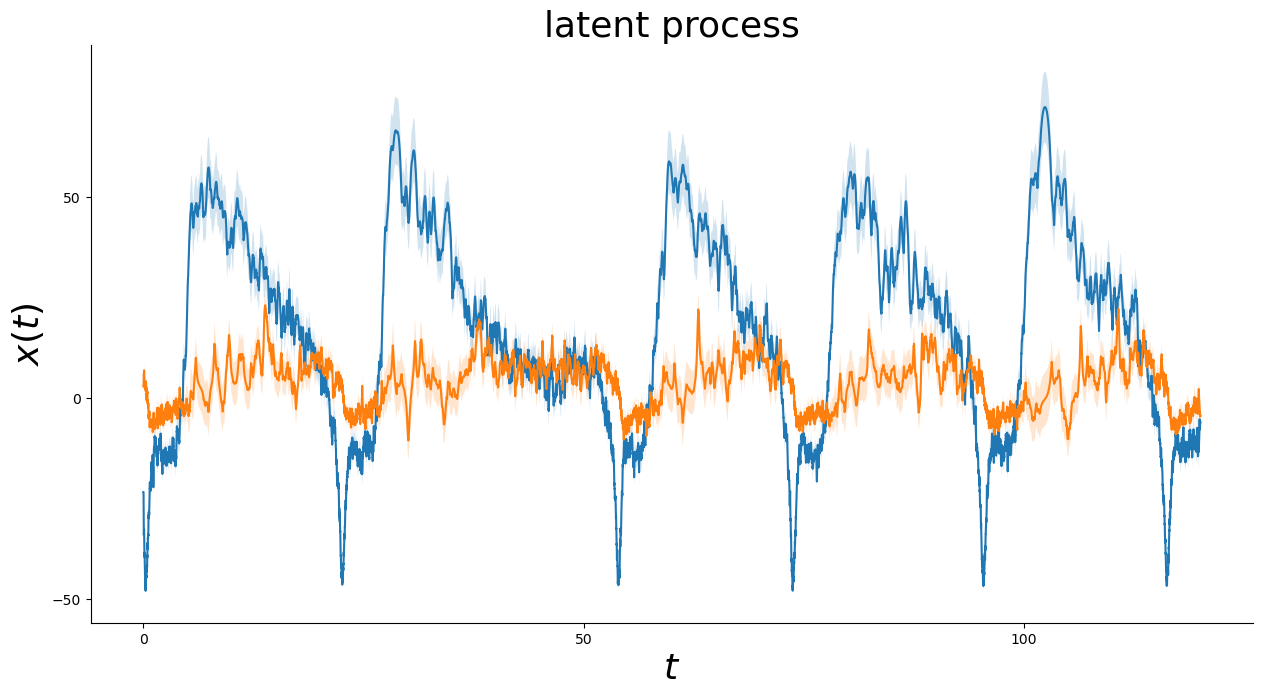

In [13]:
# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

# plot where observations lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('Graph_and_modelsave/Latent_graph_200_120_b.pdf')
plt.show()

In [14]:
# visualise learned transition function 
ngrid = 20
xmin = -2.5
xmax = 2.5
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0))

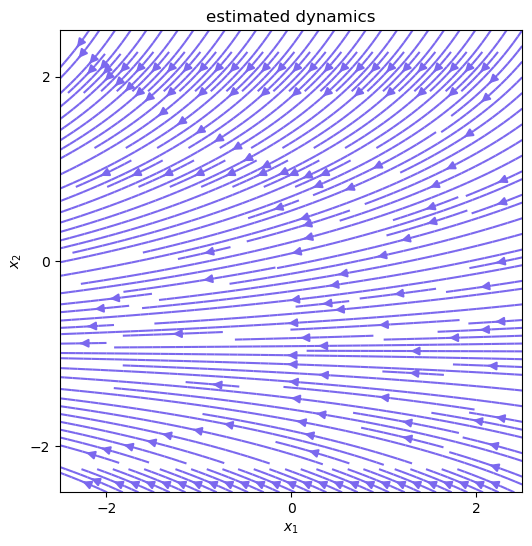

In [15]:
# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))

plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
plt.locator_params(nbins=3)
plt.savefig('Graph_and_modelsave/dynamics_200_120_b.pdf')
plt.show()